- [1] 모듈 로딩 <hr>

In [1]:
### ===> Module Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.1+cpu  Device: cpu


- [2] 데이터 준비 <hr>

In [3]:
### ===>  데이터 추출 관련 변수
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
### ===> CIFAR10 데이터 다운로드 (Train set, Test set 분리하기)
train_dataset = datasets.MNIST(root = "../data/DAY2",
                                  train = True,
                                  download = True,
                                  transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/DAY2",
                                train = False,
                                transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100.0%


Extracting ../data/DAY2\MNIST\raw\train-images-idx3-ubyte.gz to ../data/DAY2\MNIST\raw



100.0%


Extracting ../data/DAY2\MNIST\raw\train-labels-idx1-ubyte.gz to ../data/DAY2\MNIST\raw



100.0%


Extracting ../data/DAY2\MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/DAY2\MNIST\raw



100.0%

Extracting ../data/DAY2\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/DAY2\MNIST\raw



In [5]:
### ===>  데이터 확인하기 (1)
### X_train : torch.Size([32,3,32,32]) [배치사이즈, 채널, 높이, 너비]
### Y_train : torch.Size([32]) [배치사이즈] 즉, 32개 이미지에 대한 라벨

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


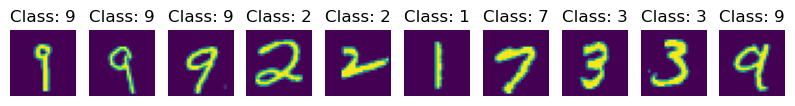

In [6]:
### ===>  데이터 확인하기 (2) 
pltsize = 1
plt.figure(figsize=(10 * pltsize, pltsize))

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(np.transpose(X_train[i], (1, 2, 0)))
    plt.title('Class: ' + str(y_train[i].item()))

- [3] 모델 설계 <hr>

In [17]:
### ===>  Convolutional Neural Network (CNN) 모델 설계하기
### X_train : torch.Size([32,3,32,32]) [배치사이즈, 채널, 높이, 너비]
### Y_train : torch.Size([32]) [배치사이즈] 즉, 32개 이미지에 대한 라벨

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = 3, padding = 1)
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 3, padding = 1)
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.fc1 = nn.Linear(7 * 7 * 16, 64)
        self.fc2 = nn.Linear(64, 28)
        self.fc3 = nn.Linear(28, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 7 * 7 * 16)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

- [4] 학습 준비 <hr>

In [18]:
### ===> Optimizer, Objective Function 설정
model = CNN().to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

criterion = nn.CrossEntropyLoss()



torch.Size([32, 1, 28, 28])


C:\Users\mathn\AppData\Local\Temp\ipykernel_17104\545445460.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


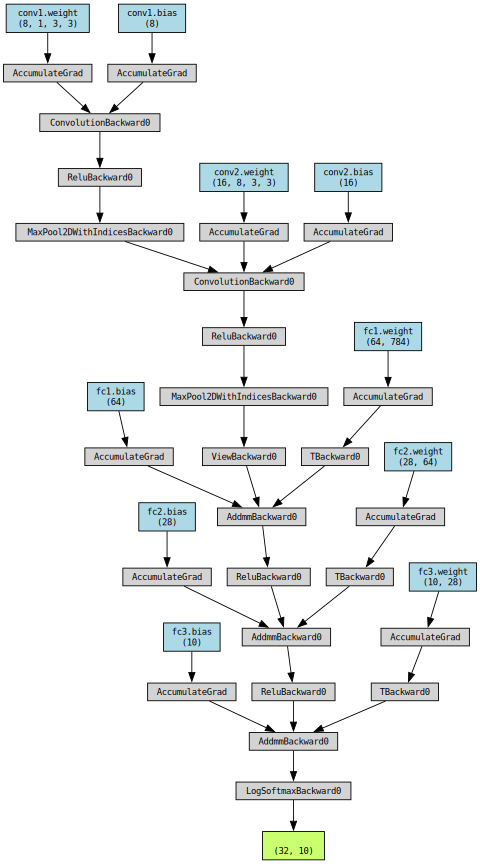

In [19]:
from torchviz import make_dot

#x=torch.randn(1,3,32,32).to(DEVICE)
#y=model(x)
print(X_train.shape)
make_dot(model(X_train),params=dict(model.named_parameters()))


In [20]:
### ===> CNN 모델 학습을 진행하며 학습 데이터에 대한 모델 성능을 확인하는 함수 정의
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")

In [21]:
### ===> 학습되는 과정 속에서 검증 데이터에 대한 모델 성능을 확인하는 함수 정의
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

- [5] 학습진행 <hr>

In [22]:
### ===> CNN 학습 실행하며 Train, Test set의 Loss 및 Test set Accuracy 확인
for epoch in range(1, EPOCHS + 1):
    
    train(epoch, model, train_loader, optimizer, log_interval = 200)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")

C:\Users\mathn\AppData\Local\Temp\ipykernel_17104\545445460.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


Train Epoch: 1 [0]	Train Loss: 2.273304
Train Epoch: 1 [200]	Train Loss: 0.666308
Train Epoch: 1 [400]	Train Loss: 0.348250
Train Epoch: 1 [600]	Train Loss: 0.163498
Train Epoch: 1 [800]	Train Loss: 0.067225
Train Epoch: 1 [1000]	Train Loss: 0.228389
Train Epoch: 1 [1200]	Train Loss: 0.337772
Train Epoch: 1 [1400]	Train Loss: 0.085890
Train Epoch: 1 [1600]	Train Loss: 0.190116
Train Epoch: 1 [1800]	Train Loss: 0.021464

[EPOCH: 1], 	Test Loss: 0.0027, 	Test Accuracy: 97.18 % 

Train Epoch: 2 [0]	Train Loss: 0.140323
Train Epoch: 2 [200]	Train Loss: 0.201434
Train Epoch: 2 [400]	Train Loss: 0.136104
Train Epoch: 2 [600]	Train Loss: 0.151212
Train Epoch: 2 [800]	Train Loss: 0.030899
Train Epoch: 2 [1000]	Train Loss: 0.020387
Train Epoch: 2 [1200]	Train Loss: 0.224063
Train Epoch: 2 [1400]	Train Loss: 0.102255
Train Epoch: 2 [1600]	Train Loss: 0.020505
Train Epoch: 2 [1800]	Train Loss: 0.060577

[EPOCH: 2], 	Test Loss: 0.0025, 	Test Accuracy: 97.41 % 

Train Epoch: 3 [0]	Train Loss: 0.029